In [24]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
import cv2
import os
import scipy.stats  # it may be necessary that you install scipy (pip install scipy)
import helpers.P5_helpers as P5_helpers

---
#### P5: Object classification

---
<div class="alert alert-info">
<p>
University of Applied Sciences Munich<br>
Dept of Electrical Enineering and Information Technology<br>
Institute for Applications of Machine Learning and Intelligent Systems (IAMLIS)<br>
&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;
&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;
&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;(c) Alfred Schöttl 2023<br>
    
</p>
</div>

In this notebook, we will design a simple object classifier which is able to distinguish between gummy bears and pieces of licorice. This notebook relies on helper functions defined in `P5_helpers.py`. Be sure to have this file in the same directory as this file. It is a good idea to go through the file after doing this assignment if you want to know details on how the specific OpenCV functions are called.


### 1. Image acquisition and preprocessing

The image acquisition is already prepared for you. We will then preprocess the image by binarizing and cleaning up the segments by some morphological operations. The pipeline is exactly the pipeline we already know.

In [25]:
def acquire(filename):
    '''get the grayscale image and the color image of filename'''
    orig_img = cv2.imread(os.path.join('imgs', filename))
    orig_img = cv2.cvtColor(orig_img, cv2.COLOR_BGR2RGB)
    grayscale_img = cv2.cvtColor(orig_img, cv2.COLOR_RGB2GRAY)
    return grayscale_img, orig_img

def preprocess(img):
    '''binarize the image and clean up the segments'''
    se = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (7,7))
    img2 = (img < 220).astype(np.uint8)
    img2 = cv2.erode(img2, se, iterations=1)
    for _ in range(2):
        img2 = cv2.dilate(img2, se, iterations=4)
        img2 = cv2.erode(img2, se, iterations=4)
    return img2

Let's test the acquisition and preprocessing steps.

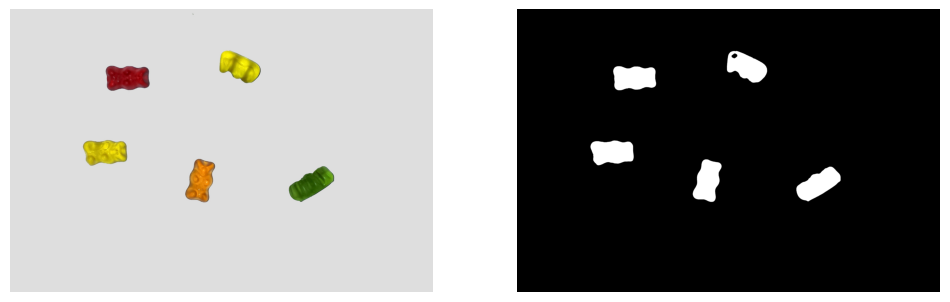

In [26]:
img_gray, img = acquire('gb.jpg')
img_preproc = preprocess(img_gray)

fig, axs = plt.subplots(1, 2, figsize=(12,12))
P5_helpers.disp_img(axs[0], img)
P5_helpers.disp_img(axs[1], img_preproc)

### 2. Segmentation and feature definition

We use the function `P5_helpers.compute_contours`, which already implements the contouring algorithm, to find a list of the contours of all segments. _Please complete the function `get_features` to obtain a list of features. There shall be two feature values for each segment._



Feature values of the 5 segments:


array([[0.76417171, 0.396645  ],
       [0.70600972, 0.38611   ],
       [0.70451734, 0.40481   ],
       [0.71051075, 0.41061   ],
       [0.69178266, 0.386035  ]])

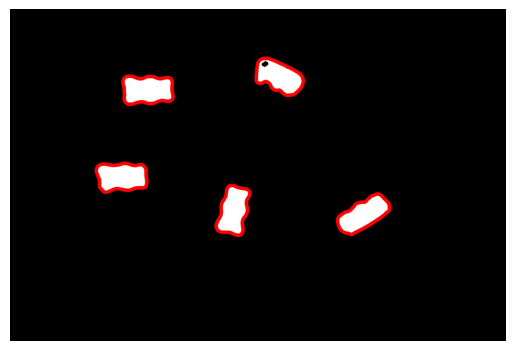

In [33]:
def get_features(contours):
    available_features = P5_helpers.features(contours)
    feats = np.zeros([len(contours), 2])
    # loop through all found segments 
    for k, contour_features in enumerate(available_features):
        ### TODO:
        # Find two appropriate features. You may derive them from the available features
        # 'perimeter', 'area', 'major_axis', 'minor_axis', 'ecc' stored in available_features.
        # As an example, 2*available_features['area'] gives you twice the area of the current 
        # segment. Take care that the derived features are roughly in the range 0..1
        feats[k] = contour_features['ecc'], contour_features['area']/100000
        ###
    return feats

fig, ax = plt.subplots()
contours, contour_img = P5_helpers.compute_contours(img_preproc)
P5_helpers.disp_img(ax, contour_img)
print(f'Feature values of the {len(contours)} segments:')
get_features(contours)

### 3. Find the model from the training data

We use the images `gb.jpg` containing 5 gummy bears as _**training samples**_ for our model and hope that all other gummy bears look similar. Our model is a normal distribution model. It is therefore sufficient to calculate the mean value and the covariance matrix ot the samples.

The function `process` contains the call to our processing steps `acquire`, `preprocess` and `compute_contours` implemented so far. It then calls the function `analyze` which shall return the features `feats`, the mean value `mu` and the covariance matrix `sig` of our data. Complete the function `analyze`.

_Hint_: `analyze` may use the numpy functions `np.mean` and `np.cov`. Observe that `np.cov` requires a matrix which contains the samples in _columns_ and the features in _rows_. 

You should see in the right-hand plot the samples, the mean value and variances of the gummy bears plotted in feature space.

[0.71539844 0.396842  ]
[[7.91743100e-04 4.80931993e-05]
 [4.80931993e-05 1.21263182e-04]]


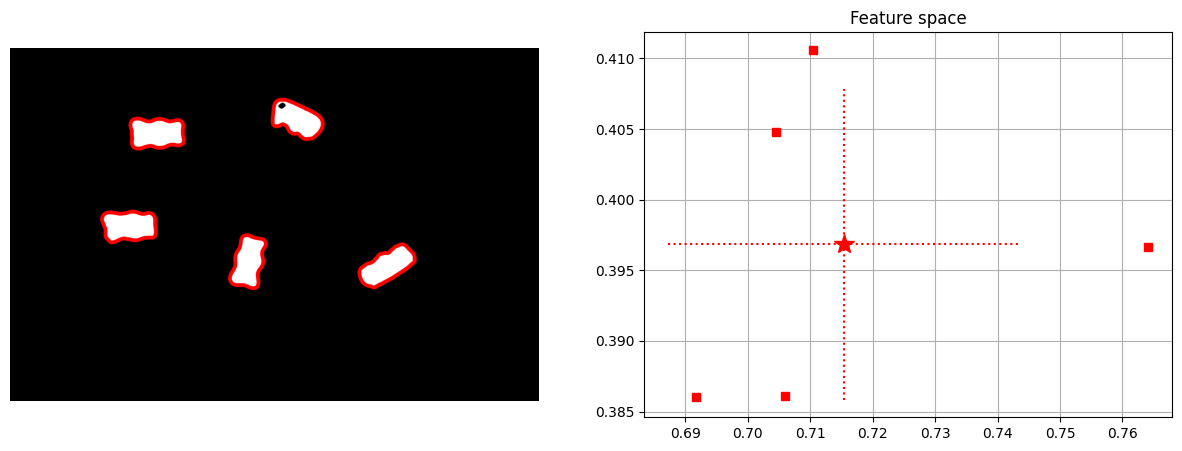

In [34]:
def process(filename, class_no):
    img_gray, img = acquire(filename)
    img_preproc = preprocess(img_gray)
    contours, contour_img = P5_helpers.compute_contours(img_preproc)
    feats, mu, sig = analyze(contours)
    
    fig, axs = plt.subplots(1, 2, figsize=(15,5))
    P5_helpers.disp_img(axs[0], contour_img)
    P5_helpers.plot_feats(axs[1], feats, mu, sig, class_no)
    plt.title('Feature space')
    return feats, mu, sig

def analyze(contours):
    ### TODO:
    # Assign the variables F, mu, sig the features, the mean value and the empirical covariance matrix.
    # - Use the already implemented `get_features` to obtain the features 
    # - Use `np.mean` to compute the mean value. Make sure that the mean value is a two-dimensional vector!
    # - Use `np.cov` to compute the covariance matrix. Make sure that `np.cov` gets a data matrix with the 
    #   samples in columns and the features in rows.
    F   = get_features(contours) 
    mu  = np.mean(F, axis= 0)
    sig = np.cov(F.T)
    print(mu)
    print(sig)
    return F, mu, sig

feats_gb, mu_gb, sig_gb = process('gb.jpg', 0)

Repeat the same with class 1 (licorice).

[0.53139621 0.38277929]
[[ 0.00487305 -0.00026923]
 [-0.00026923  0.00526468]]


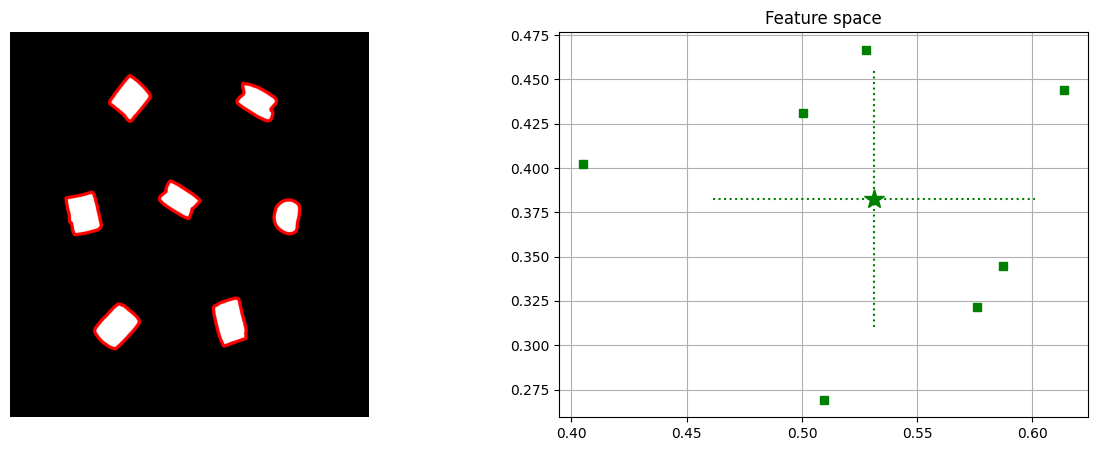

In [35]:
feats_lic, mu_lic, sig_lic = process('lic.jpg', 1)

Let us plot the features of class 0 (gummy bear, plotted in red) and class 1 (licorice, plotted in green) as well as the pdfs of the normal distribution. We call the adaption of the model to the training data _**learning**_ or _**training**_.

_Tip:_ You may not see the features in the plot clearly if they are too close together or out of the range 0..1. Please consider to rescale the chosen features in the function `get_features` in this case. It is also possible to adjust the borders 0 and 1 in the two `np.linspace` commands in the function `P5_helpers.visualize_model`.

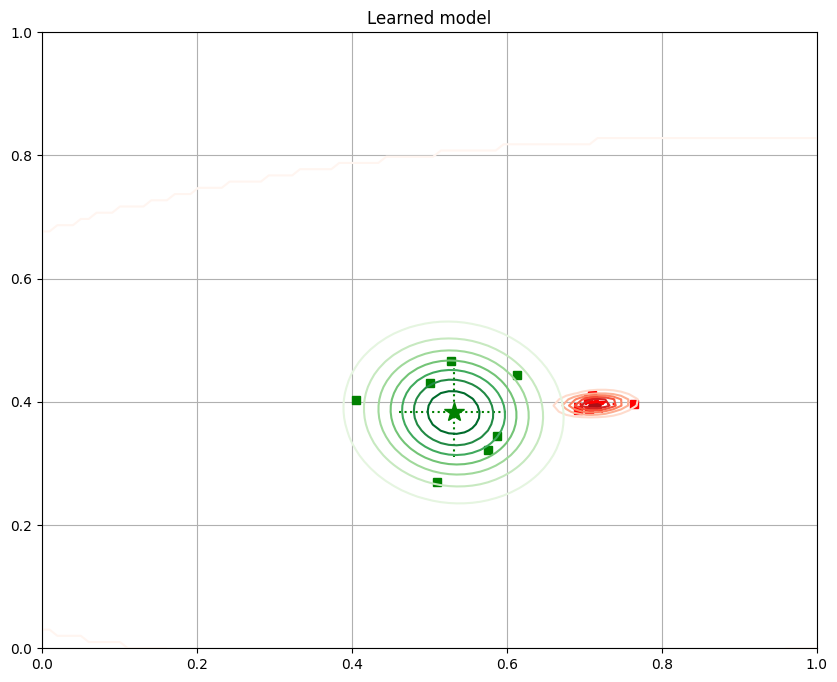

Rendered in 3D (this may fail if you do not have installed the 3D support):


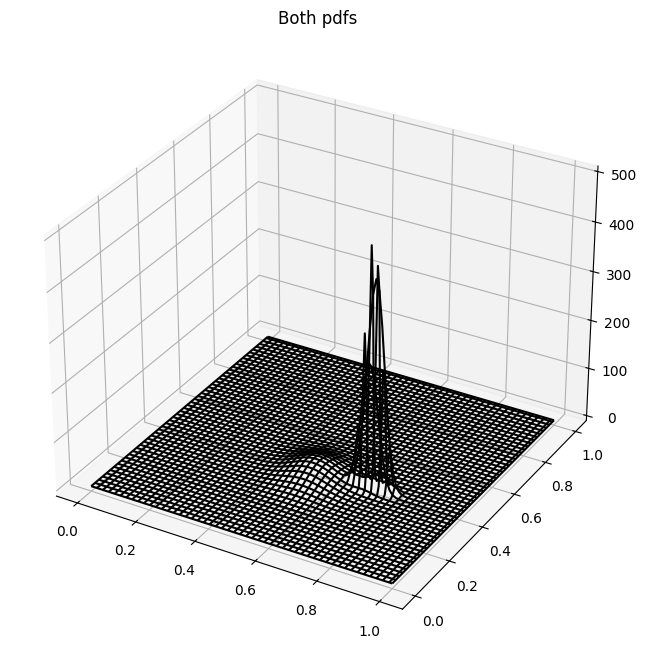

In [36]:
P5_helpers.visualize_model(feats_gb, mu_gb, sig_gb, feats_lic, mu_lic, sig_lic)

### 4. Bayes classifier

Now we are ready to design the Bayes classifier. Let `feats` be the features of an unknown sample. The function `classify_sample` finds the probability densities that this feature vector occurs given that the sample is a gummy bear/piece of licorice. Assume that there are an equal amount of gummy bears and pieces of licorice in the underlying set. The `scipy` function `multivariate_normal(mu, sig).pdf` can be used to compute the pdf of a two-dimensional normal distribution with expectation value mu and covariance matrix sig.

Define a rule to decide whether class 0 or class 1 is more likely for the given feature vector utilizing the Bayes' formula.

_Hint:_ Observe that the denominator in the quotient of Bayes' formula is identical for class 0 and class 1. You need not implement it if you only want to compare different class probabilities.

In [38]:
def classify_sample(feats, mu_gb, sig_gb, mu_lic, sig_lic):
    pdf_gb = scipy.stats.multivariate_normal(mu_gb, sig_gb).pdf    
    pdf_lic = scipy.stats.multivariate_normal(mu_lic, sig_lic).pdf    
    p_feat_given_gb = pdf_gb(feats)
    p_feat_given_lic = pdf_lic(feats)
    ### TODO: 
    # - Define the variables `p_gb` and `p_lic` (the probability of drawing a gummy 
    #   bear/piece of licorice out of the underlying set) 
    # - Define a rule deciding which class number is more likely using Bayes' formula.
    p_gb  = 0.5
    p_lic = 0.5
    if (p_feat_given_gb*p_gb) > (p_feat_given_lic*p_lic):
        class_no = 0
    else: class_no = 1
    ##
    return class_no

### 5. Inference

_**Inference**_ is the process of application of the model to unknown data. We define a function `inference` which gets the acquired grayscale image `img_gray` and the color image `img`. It repeats the same preprocessing steps we did with the training data, finds all segments and classifies them. Finally, it draws a rectangle around every segment in the color of the inferred class and returns the modified image.

In [39]:
def inference(img_gray, img):
    img_preproc = preprocess(img_gray)
    contours, contour_img = P5_helpers.compute_contours(img_preproc)
    feats = get_features(contours)
    print("Number of segments found: ", len(contours))
    for contour, feat in zip(contours, feats):
        x, y, w, h = cv2.boundingRect(contour)
        start_point = (x, y)
        end_point = (x+w, y+h)
        class_no = classify_sample(feat, mu_gb, sig_gb, mu_lic, sig_lic)
        col = (255,0,0) if class_no == 0 else (0,255,0)
        img = cv2.rectangle(img, start_point, end_point, col, 10)
    return img

Let's try it with the image `samples.jpg`.

Number of segments found:  10


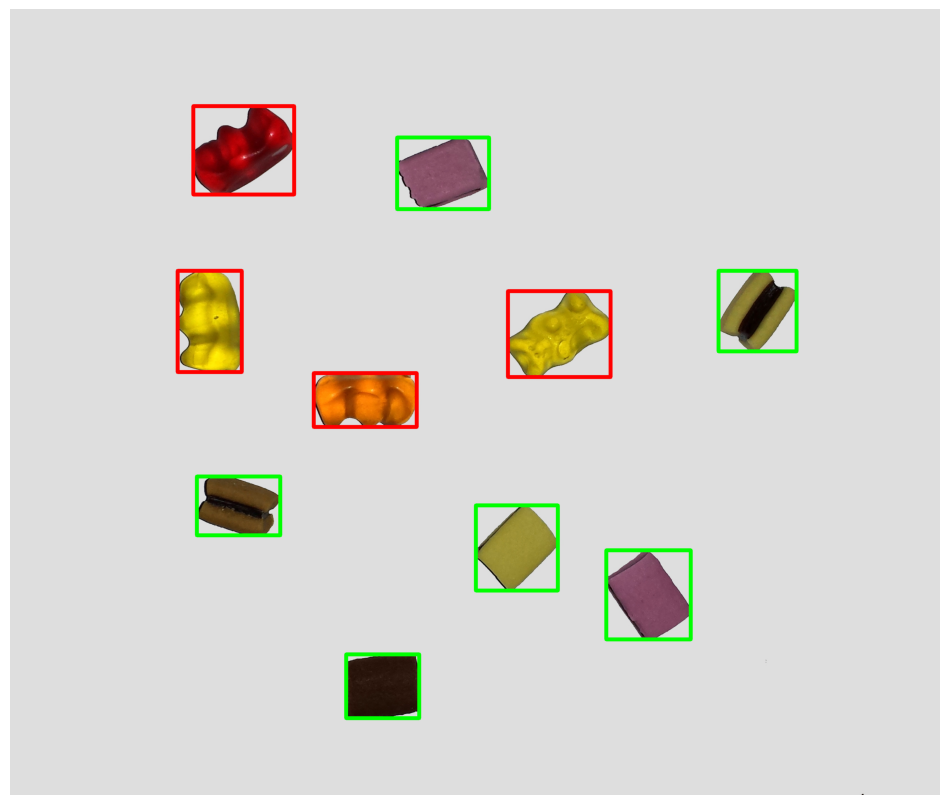

In [40]:
img, orig_img = acquire("samples.jpg")
result = inference(img, orig_img)
fig, ax = plt.subplots(figsize=(12,12))
P5_helpers.disp_img(ax, result)

### Further things to do if you dare:

We have also provided for you further test samples `samples2.jpg` and `samples3.jpg`. They differ significantly from `samples.jpg` and the training data. Identify the difference and try to make your classifier work even with these samples. (This is difficult!)

Number of segments found:  1


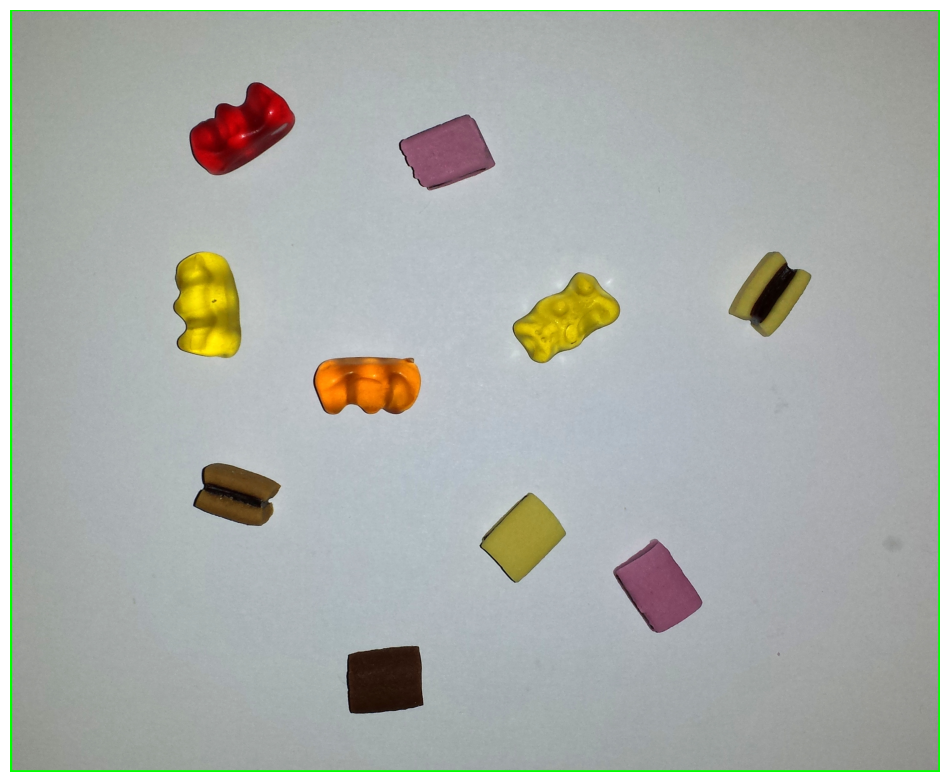

In [41]:
img, orig_img = acquire("samples2.jpg")
result = inference(img, orig_img)
fig, ax = plt.subplots(figsize=(12,12))
P5_helpers.disp_img(ax, result)